# Population-level dynamics


In [19]:
from nufeb_tools import utils,plot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from scipy.signal import find_peaks
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed

In [20]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [21]:
DIR = Path(r'E:\sucrose\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]

In [22]:
def collect_data(folder):
    x = utils.get_data(directory=str(folder))
    try:
        temp = x.biomass.reset_index()[['Hours','cyano','ecw']]
        temp.loc[:,'IPTG'] = x.IPTG
        temp.loc[:,'Sucrose']=x.avg_con['Sucrose'].reset_index()['Sucrose']
        difference = np.diff(x.avg_con['Sucrose'].values,prepend=0)
        pks,props=find_peaks(np.abs(difference),width=5,prominence=1e-3)
        if pks.size ==0:
            print(f'No peaks found in {folder}')
            temp.loc[:,'ss_time'] = pd.NA
            temp.loc[:,'suc_end'] = x.avg_con['Sucrose'].iloc[-30:].mean()
        else:
            if pks[0] > len(x.avg_con.index):
                temp.loc[:,'ss_time'] = x.avg_con.index[-1]
                temp.loc[:,'suc_end'] = x.avg_con['Sucrose'].iloc[-30:].mean()
            else:
                temp.loc[:,'ss_time'] = x.avg_con.index[int(pks[0]+props['widths'][0])]
                temp.loc[:,'suc_end'] = x.avg_con['Sucrose'].iloc[-int(pks[0]+props['widths'][0]):].mean()
        temp.loc[:,'suc_max'] = x.avg_con['Sucrose'].max()
        
        temp.loc[:,'pop_ratio'] = temp.ecw/temp.cyano
    except IndexError:
        print(f'Index error {folder}')
    return temp


In [23]:
if Path(r'E:\sucrose.pkl').is_file():
    df = pd.read_pickle(r'E:\sucrose.pkl')
else:
    with ProgressParallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(collect_data)(folder) for folder in sorted(folders))
    df = pd.concat(temp,ignore_index=True)
    #df.loc[:,'pop_ratio'] = df.ecw/df.cyano
    df.to_pickle(r'E:\sucrose.pkl')
# Remove oscillations at end of high IPTG condition
#df.loc[(df.IPTG==1) & (df.Hours > 85),'Sucrose'] = pd.NA

<AxesSubplot:xlabel='Hours', ylabel='Sucrose'>

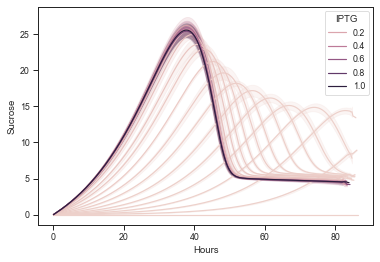

In [24]:
sns.lineplot(x='Hours',y='Sucrose',hue='IPTG',ci='sd',data=df)

In [25]:
""" from matplotlib.ticker import FormatStrFormatter
piv = df.groupby(['IPTG','Hours']).mean().reset_index().pivot('IPTG','Hours','Sucrose')
f, ax = plt.subplots(figsize=(8,8))
g= sns.heatmap(piv,ax=ax,xticklabels=35)
from matplotlib.ticker import FormatStrFormatter

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
#cbar.ax.set_ylabel('Sucrose (mM)')
ax.set_xlabel(r'Time (hours)')
ax.set_ylabel(r'IPTG (mM)') """

#ax.ticklabel_format(axis='y',style='sci')

" from matplotlib.ticker import FormatStrFormatter\npiv = df.groupby(['IPTG','Hours']).mean().reset_index().pivot('IPTG','Hours','Sucrose')\nf, ax = plt.subplots(figsize=(8,8))\ng= sns.heatmap(piv,ax=ax,xticklabels=35)\nfrom matplotlib.ticker import FormatStrFormatter\n\n#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))\n#ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))\n#cbar = g.collections[0].colorbar\n#cbar.set_ticks([0, 25, 50, 75,100])\n#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])\n#cbar.ax.set_ylabel('Sucrose (mM)')\nax.set_xlabel(r'Time (hours)')\nax.set_ylabel(r'IPTG (mM)') "

In [26]:
df.head()

,Hours,cyano,ecw,IPTG,Sucrose,ss_time,suc_end,suc_max,pop_ratio
0,0.000000,46722.82,9636.472,1.0,9.991236e-20,52.5,10.693888,25.560476,0.206248
1,0.277778,47510.96,9633.453,1.0,9.519912e-02,52.5,10.693888,25.560476,0.202763
2,0.555556,48312.40,9635.659,1.0,1.886316e-01,52.5,10.693888,25.560476,0.199445
3,0.833333,49127.35,9642.942,1.0,2.832975e-01,52.5,10.693888,25.560476,0.196285
4,1.111111,49956.05,9655.274,1.0,3.792293e-01,52.5,10.693888,25.560476,0.193275


In [27]:
def mu_sweep2(folder):
    
    try:
        x = utils.get_data(directory=folder)
        temp = pd.DataFrame([[x.IPTG,x.biomass.iloc[-1,2]/x.biomass.iloc[-1,1],
            x.metadata['ecw']['GrowthRate'],
            x.metadata['ecw']['GrowthRate']/x.metadata['cyano']['GrowthRate']]],
            columns=['IPTG','Biomass_ratio','mu_ecw','mu_ratio'])
        return temp
    except:
        print('Error in ' + str(folder))
        return
DIR = Path(r'E:\mu-sweep\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]
if Path(r'E:\mu-sweep.pkl').is_file():
    mu_df = pd.read_pickle(r'E:\mu-sweep.pkl')
else:
    with ProgressParallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(mu_sweep2)(folder) for folder in sorted(folders))
    mu_df = pd.concat(temp,ignore_index=True)
    mu_df.to_pickle(r'E:\mu-sweep.pkl')



In [28]:
mu_df.head()

,IPTG,Biomass_ratio,mu_ecw,mu_ratio
0,1.0,0.000599,0.000002,0.085185
1,1.0,1.644108,0.000117,6.190476
2,1.0,0.002444,0.000007,0.355556
3,1.0,2.348787,0.000240,12.698413
4,1.0,2.565110,0.000386,20.423280


In [29]:
DIR = Path(r'E:\population-stability\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]
def population_stability2(folder):
    x = utils.get_data(directory=str(folder))
    temp = x.biomass.reset_index()[['Hours','cyano','ecw']]
    temp.loc[:,'IPTG'] = x.IPTG
    temp.loc[:,'Sucrose']=x.avg_con['Sucrose'].reset_index()['Sucrose']
    temp.loc[:,'pop_ratio'] = temp.ecw/temp.cyano
    temp.loc[:,'seed_ratio'] =x.ntypes.reset_index()['ecw'][0]/x.ntypes.reset_index()['cyano'][0]
    #df=df.append(temp,ignore_index=True)
    
    return temp
if Path(r'E:\population-stability.pkl').is_file():
    population_df= pd.read_pickle(r'E:\population-stability.pkl')
else:
    with ProgressParallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(population_stability2)(folder) for folder in sorted(folders))
    population_df = pd.concat(temp,ignore_index=True)
    #population_df.loc[:,'pop_ratio'] = population_df.ecw/population_df.cyano
    population_df.to_pickle(r'E:\population-stability.pkl')

In [30]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols

In [31]:

ratios=[0.00206914,0.00428133,0.01274275,1.0]
labels = [r'2.1 $\mu$M',r'4.3 $\mu$M',r'13 $\mu$M','1 mM']
sorted(df.IPTG.unique())

[0.001,
 0.00143845,
 0.00206914,
 0.00297635,
 0.00428133,
 0.00615848,
 0.00885867,
 0.01274275,
 0.01832981,
 0.02636651,
 0.0379269,
 0.05455595,
 0.078476,
 0.11288379,
 0.16237767,
 0.23357215,
 0.33598183,
 0.48329302,
 0.6951928,
 1.0]

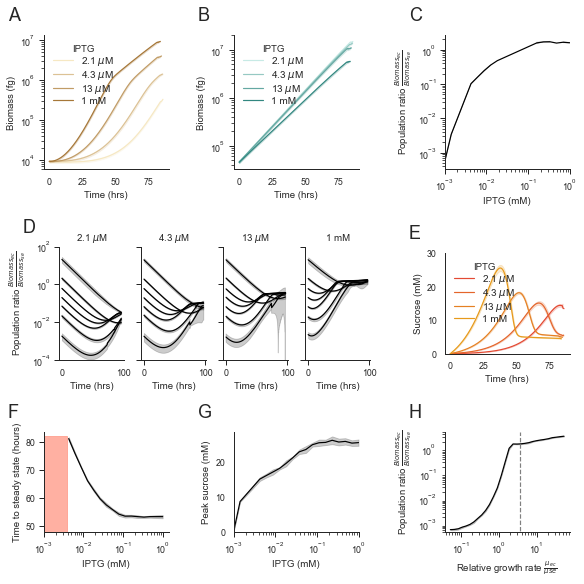

In [59]:

fig = plt.figure(constrained_layout=True, figsize=(8,8))
widths = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
heights = [1, .75, .75]
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)


gs0 = gridspec.GridSpec(3, 15, figure=fig,wspace=.7,hspace=.1, width_ratios=widths,
                          height_ratios=heights)
sns.set_context('paper')
sns.set_style('ticks')
#colors = ['#e34a33','#fdbb84','#fee8c8']
cya_cmap = colorFader('#c7eae5','#01665e',len(ratios))
ecw_cmap = colorFader('#f6e8c3','#8c510a',len(ratios))
cyano_color = '#007d3d'
ecw_color = '#e8b513'
#cya_cmap = colorFader('#e2e2e2',cyano_color,len(ratios))
#ecw_cmap = colorFader('#e2e2e2',ecw_color,len(ratios))
suc_cmap = colorFader('#e34a33',ecw_color,len(ratios))
# Biomass vs time
gs00 = gs0[0,:5].subgridspec(1,2)

#ax1=gs00.subplots(sharey=True)
ax1 = fig.add_subplot(gs0[0, :5])
sns.lineplot(x='Hours',y='ecw',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax1,palette=ecw_cmap)

ax1.set_yscale('log')
ax1.set_xlabel('Time (hrs)')

ax1.set_ylabel('Biomass (fg)')
handles, _ = ax1.get_legend_handles_labels()

ax1.legend(handles,labels,frameon=False,title='IPTG',fontsize=10,labelspacing=0.1)
#ax1.legend([f'{x:.1e}' for x in ratios],frameon=False,title='IPTG (mM)')

ax2 = fig.add_subplot(gs0[0, 5:10])
sns.lineplot(x='Hours',y='cyano',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax2,palette=cya_cmap)
handles, _ = ax2.get_legend_handles_labels()

ax2.legend(handles,labels,frameon=False,title='IPTG',fontsize=10,labelspacing=0.1)
#ax2.legend([f'{x:.1e}' for x in ratios],frameon=False,title='IPTG (mM)')
ax2.set_xlabel('Time (hrs)')
ax2.set_ylabel('Biomass (fg)')
ax2.set_yscale('log')
# Population stability dynamics
gs01 = gs0[1,:10].subgridspec(1,len(ratios))


ax3=gs01.subplots(sharey=True)
for ratio in ratios:
    for seed in population_df.seed_ratio.unique():
        sns.lineplot(x='Hours',y='pop_ratio',ci='sd',data=population_df.loc[(population_df.IPTG==ratio) & (population_df.seed_ratio==seed)],color='k',ax=ax3[ratios.index(ratio)])
    #ax3[sucroseRatios.index(S)].plot(X,Y,c='k')
    #ax3[ratios.index(ratio)].set_title(f'{ratio:.1e}')
_=[ax3[idx].set_title(label) for idx,label in enumerate(labels)]

""" for s in ratios:
    y_line = df.loc[(df.Hours==df.Hours.iloc[-1]) & (df.IPTG == s),'pop_ratio'].mean()
    if y_line.size > 0:
        ax3[ratios.index(s)].plot([0,100],[y_line,y_line], color='red', linestyle='--') """
for ax in ax3.ravel():
    ax.set_yscale('log')
    ax.set_ylim([1e-4,1e2])
    ax.set_xlabel('Time (hrs)')
ax3[0].set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
ax3[2].set_xlabel('Time (hrs)')

# Population ratio vs sucrose secretion level

ax4 = fig.add_subplot(gs0[0, 10:])
sns.lineplot(x='IPTG',y='pop_ratio',ci='sd',data=df.loc[df.Hours==df.Hours.iloc[-1]],ax=ax4,color='k')
ax4.set(xscale="log")
ax4.set(yscale="log")
ax4.set_xlabel('IPTG (mM)')
ax4.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
ax4.set_xlim(1e-3,1e0)

# Sucrose over time
with sns.axes_style("white"):
    ax5 = fig.add_subplot(gs0[1, 10:])
    sns.lineplot(x='Hours',y='Sucrose',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax5,palette=suc_cmap)
    ax5.set_ylabel('Sucrose (mM)')
    ax5.set_xlabel('Time (hrs)')
    handles, _ = ax5.get_legend_handles_labels()

    ax5.legend(handles,labels,frameon=False,title='IPTG',fontsize=10,labelspacing=0.1)
    #ax6.legend([f'{x:.1e}' for x in ratios],frameon=False,title='IPTG (mM)',loc='upper left')
    ax5.set_ylim(0,30)

# Time to steady state


ax6 = fig.add_subplot(gs0[2, :5])
#ax7.bar(ratios,ss_time)#,color=colors
sns.lineplot(x='IPTG',y='ss_time',ci='sd',data=df,ax=ax6,color='k')
i_min = df.groupby(['IPTG']).mean()['ss_time'].dropna().index.min()
s_min= df.groupby(['IPTG']).mean()['ss_time'].dropna().min()
s_max= df.groupby(['IPTG']).mean()['ss_time'].dropna().max()

#x1 = ax7.plot([1e-3,1e-3],[s_min,s_max],color='tomato',alpha=0.5)
#x2 = ax7.plot([i_min,i_min],[s_min,s_max],color='tomato',alpha=0.5)
ax6.fill_betweenx([s_min*0.9,s_max*1.01],1e-3,i_min*.9,color='tomato',alpha=0.5)
ax6.set_xlabel('IPTG (mM)')
ax6.set_ylabel('Time to steady state (hours)')
ax6.set(xscale="log")
ax6.set_xlim(left=1e-3)
ax6.set_ylim(bottom=s_min*0.9)
# Peak sucrose

ax7 = fig.add_subplot(gs0[2, 5:10])
sns.lineplot(x='IPTG',y='suc_max',ci='sd',data=df,ax=ax7,color='k')
#ax8.bar(ratios,suc_max)
ax7.set_xlabel('IPTG (mM)')
ax7.set_ylabel('Peak sucrose (mM)')
ax7.set(xscale="log")
ax7.set_xlim(1e-3,1e0)
ax7.set_ylim(bottom=0)

# Population ratio vs relative growth rate
#
ax8= fig.add_subplot(gs0[2, 10:])
sns.lineplot(x='mu_ratio',y='Biomass_ratio',ci='sd',data=mu_df.loc[mu_df.IPTG==1],ax=ax8,color='k')
#ax5.plot(dmu,Ratio2,marker='o',color='k')
ax8.set(xscale="log")
ax8.set(yscale="log")
ax8.set_xlabel(r'Relative growth rate $\frac{\mu_{ec}}{\mu{se}}$')
ax8.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
ax8.plot([3.55,3.55],[1e-4,5e0], color='gray', linestyle='--')
ax8.set_ylim(5e-4,5e0)
# Steady state sucrose

""" ax9 = fig.add_subplot(gs0[2, 10:])
#ax9.bar(ratios,suc_end)
sns.lineplot(x='IPTG',y='suc_end',ci='sd',data=df,ax=ax9,color='k')
ax9.set_xlabel('IPTG (mM)')
ax9.set_ylabel('Steady state sucrose (mM)')
ax9.set(xscale="log")
ax9.set_xlim(1e-3,1e0)
suc_end_min= df.groupby(['IPTG']).mean()['suc_end'].dropna().min()
suc_end_max= df.groupby(['IPTG']).mean()['suc_end'].dropna().max()
ax9.fill_betweenx([0,suc_end_max*1.01],1e-3,i_min*.9,color='tomato',alpha=0.5)
ax9.set_ylim(bottom=0) """

label_panel(ax1,'A')
label_panel(ax2,'B')
label_panel(ax3[0],'D')
label_panel(ax4,'C')
label_panel(ax5,'E')
label_panel(ax6,'F')
label_panel(ax7,'G')
label_panel(ax8,'H')

#label_panels(ax1[0],ax3[0],ax4,ax5,ax6,ax7,ax8,ax9, letters='ABCDEFGH')
for ax in [ax7,ax8]:
    ax.tick_params(left=False)
for ax in [ax1,ax2,ax3[0]]:
    ax.tick_params(bottom=False)
sns.despine()
plt.show()
fig.savefig('../figures/Whole culture analysis V3.png',dpi=600)

In [33]:
np.logspace(-3,0,20)

array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])

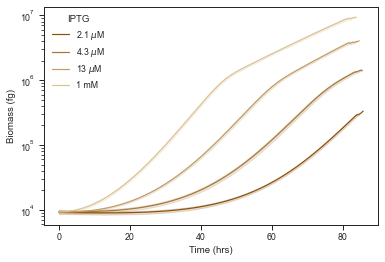

In [48]:
f, ax =plt.subplots()
sns.lineplot(x='Hours',y='ecw',hue='IPTG',data=df[df.IPTG.isin(ratios)],ci='sd',ax=ax,palette=ecw_cmap)

ax.set_yscale('log')
ax.set_xlabel('Time (hrs)')

ax.set_ylabel('Biomass (fg)')
handles, labels = ax.get_legend_handles_labels()
labels = [r'2.1 $\mu$M',r'4.3 $\mu$M',r'13 $\mu$M','1 mM']
ax.legend(handles,labels,frameon=False,title='IPTG')

In [35]:
def get_hill_params(df):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
            DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        Family (str)
            Name of AHL family to fit

    """
    import scipy.optimize as opt
    fit = list()
    fits = pd.DataFrame(columns=['Slope','EC50','Min','Max'])
    #data = Data[Data.Family =='LuxR']
    #cmap = matplotlib.cm.get_cmap(colormap)
    #colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
    max_ = df.Biomass_ratio.max()
    min_ = df.Biomass_ratio.min()
    #print(replicate,iptg)
    def func(x, a, b):
        return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
    (a_, b_), _ = opt.curve_fit(func, np.log10(df.mu_ratio), np.log10(df.Biomass_ratio),maxfev=10000)
    fits=fits.append(pd.DataFrame([[a_,b_,min_,max_]],columns=['Slope','EC50','Min','Max']),ignore_index=True)
    fit.append(fits)
    
    return pd.concat(fit,ignore_index=True)

In [36]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Determine the maximum biomass before sucrose oscillations occur

In [37]:
DIR = Path(r'E:\sucrose\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]
def biomass(folder):
    x = utils.get_data(directory=str(folder))
    temp = x.biomass.reset_index()[['Hours','cyano','ecw']]
    temp.loc[:,'IPTG'] = x.IPTG
    temp.loc[:,'Sucrose']=x.avg_con['Sucrose'].reset_index()['Sucrose']
    return temp
if Path(r'E:\suc-biomass.pkl').is_file():
    bm = pd.read_pickle(r'E:\suc-biomass.pkl')
else:
    with ProgressParallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(biomass)(folder) for folder in sorted(folders))
    bm = pd.concat(temp,ignore_index=True)
    #df.loc[:,'pop_ratio'] = df.ecw/df.cyano
    bm.to_pickle(r'E:\suc-biomass.pkl')

In [38]:
bm.ecw = bm.ecw*1e-18
bm.cyano=bm.cyano*1e-18
bm['biomass']=bm.cyano+bm.ecw
bm.head()

,Hours,cyano,ecw,IPTG,Sucrose,biomass
0,0.000000,4.672282e-14,9.636472e-15,1.0,9.991236e-20,5.635929e-14
1,0.277778,4.751096e-14,9.633453e-15,1.0,9.519912e-02,5.714441e-14
2,0.555556,4.831240e-14,9.635659e-15,1.0,1.886316e-01,5.794806e-14
3,0.833333,4.912735e-14,9.642942e-15,1.0,2.832975e-01,5.877029e-14
4,1.111111,4.995605e-14,9.655274e-15,1.0,3.792293e-01,5.961132e-14


<AxesSubplot:xlabel='Hours', ylabel='Sucrose'>

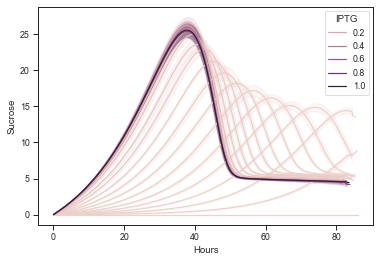

In [39]:
sns.lineplot(x='Hours',y='Sucrose',hue='IPTG',ci='sd',data=bm.loc[bm.biomass <1.5e-11])

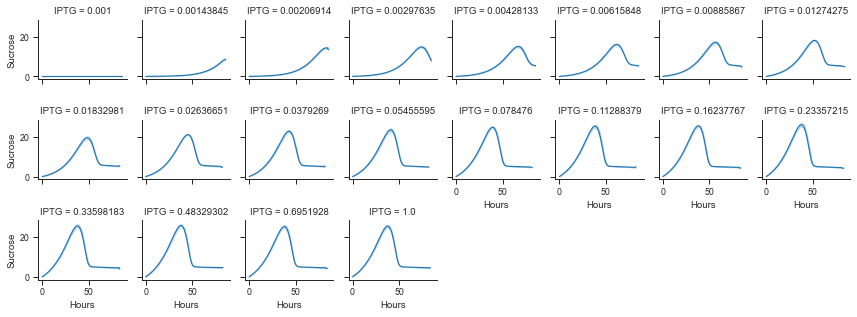

In [40]:
grid = sns.FacetGrid(bm.loc[bm.biomass <1.5e-11], col="IPTG", palette="tab20c",
                     col_wrap=8, height=1.5)
grid.map(sns.lineplot, "Hours", "Sucrose", ci='sd')

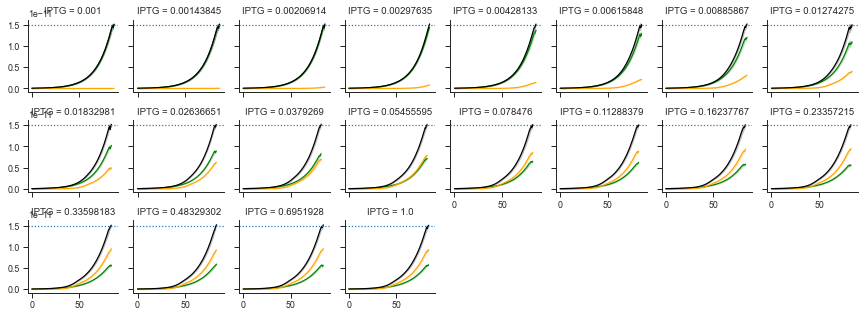

In [41]:
grid = sns.FacetGrid(bm, col="IPTG", palette="tab20c",
                     col_wrap=8, height=1.5)

grid.map(sns.lineplot, "Hours", "cyano", ci='sd',color='green')
grid.map(sns.lineplot, "Hours", "ecw", ci='sd',color='orange')
grid.map(sns.lineplot, "Hours", "biomass", ci='sd',color='k')
grid.map(plt.axhline,y=1.5e-11, linestyle=":")


In [42]:
3.4091902801428087-3.4897341206041004

-0.0805438404612917